In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
%matplotlib inline

In [121]:
data = pd.read_csv("./data/rcar/BOT_data_rcar_20170103_20170102_part0.csv")

In [122]:
data.head()

,car_id,date_time,lat,lon,power_mode,mileage,speed,fuel_consumption
0,r74415,2017-01-02 13:02:21,31.027729,121.599790,dph,4583.0,0.0,141494
1,r76180,2017-01-02 14:07:35,31.289532,121.516822,dph,1253.0,20.9,178217
2,r76180,2017-01-02 14:07:40,31.289269,121.516912,dph,1253.0,20.5,178221
3,r76180,2017-01-02 14:07:55,31.288576,121.517211,dph,1253.0,18.6,178231
4,r76180,2017-01-02 14:18:10,31.255289,121.431247,dph,1263.0,67.5,179000


In [123]:
data.describe()

,lat,lon,mileage,speed,fuel_consumption
count,181293.000000,181293.000000,181290.000000,181293.000000,1.812930e+05
mean,30.517165,118.666182,3919.900938,27.553137,3.708092e+05
std,4.567048,17.747698,3546.468977,28.775631,3.401201e+05
min,0.000000,0.000000,45.000000,0.000000,2.200000e+01
25%,31.116326,121.298148,1252.000000,0.000000,1.210190e+05
50%,31.228217,121.417272,2959.000000,19.400000,2.822090e+05
75%,31.296693,121.515648,5048.000000,47.000000,5.190420e+05
max,32.007936,121.845265,18715.000000,127.300000,1.790219e+06


clean the data with lat = 0.0 and lon = 0.0

In [124]:
data = data[(data['lat'] > 0.1) & (data['lon'] > 0.1)]

In [125]:
data.describe()

,lat,lon,mileage,speed,fuel_consumption
count,177329.000000,177329.000000,177327.000000,177329.000000,1.773290e+05
mean,31.199344,121.318838,3919.110440,27.774327,3.712931e+05
std,0.201346,0.450558,3549.156864,28.777125,3.412725e+05
min,30.064283,117.891051,45.000000,0.000000,2.200000e+01
25%,31.127914,121.311929,1253.000000,0.000000,1.210450e+05
50%,31.233113,121.420471,2959.000000,20.000000,2.817740e+05
75%,31.298267,121.517641,5048.000000,47.100000,5.191470e+05
max,32.007936,121.845265,18715.000000,127.300000,1.790219e+06


convert the date from string to the datetime object

In [126]:
data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

draw the cars during one hour

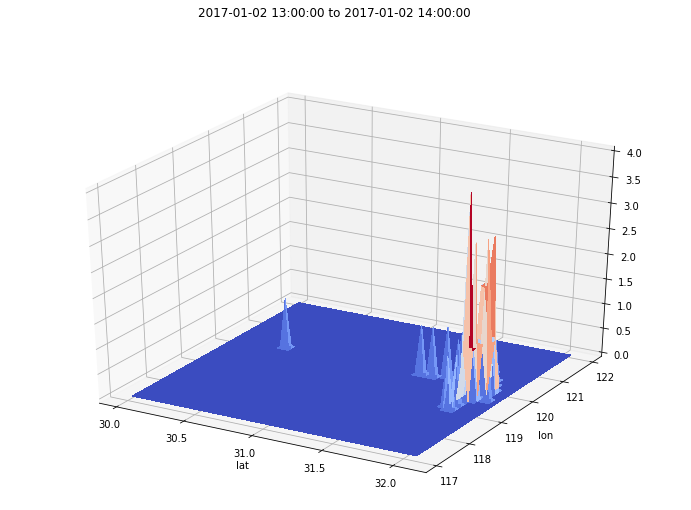

In [142]:
def draw_hour_hist(hour_begin, hour_end):
    bins_ctr = 50
    lat_min, lat_max = 30.0, 32.1
    lon_min, lon_max = 117, 122
    x_gap = (lat_max - lat_min) / bins_ctr / 2;
    y_gap = (lon_max - lon_min) / bins_ctr / 2;
    data_hour = data[(hour_begin <= data['date_time']) & (data['date_time'] < hour_end)]
    data_hour = data_hour.drop_duplicates(['car_id'])
    if data_hour.shape[0] < 2:
        return
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    hist, xedges, yedges = np.histogram2d(data_hour['lat'], data_hour['lon'],
                                         bins = bins_ctr, range = [[lat_min, lat_max], [lon_min, lon_max]])
    xpos, ypos = np.meshgrid(xedges[:-1] + x_gap, yedges[:-1] + y_gap)
    ax.plot_surface(xpos, ypos, hist, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
    ax.set_xlabel("lat")
    ax.set_ylabel("lon")
    #ax.set_zlim(0, 2000)
    fig.suptitle("{} to {}".format(hour_begin, hour_end))
    plt.show()
    fig.savefig("./fig/{}.png".format(hour_begin))
draw_hour_hist(datetime(2017, 1, 2, 13), datetime(2017, 1, 2, 14))

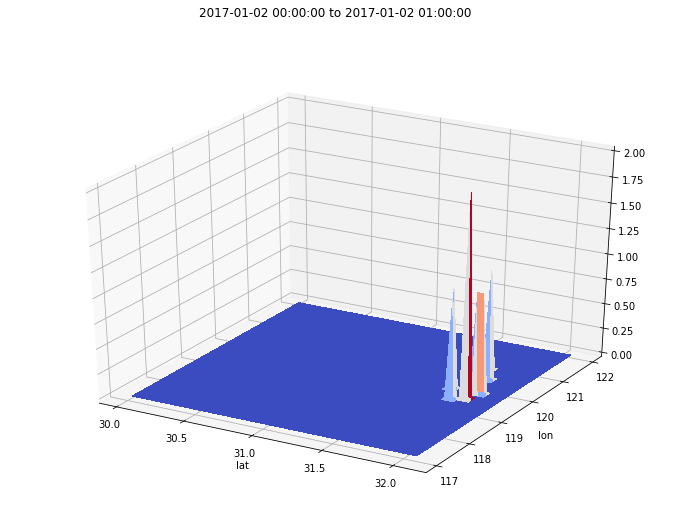

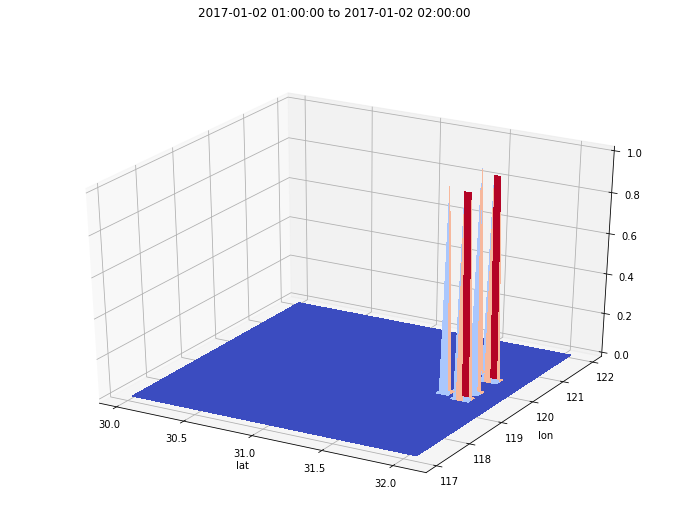

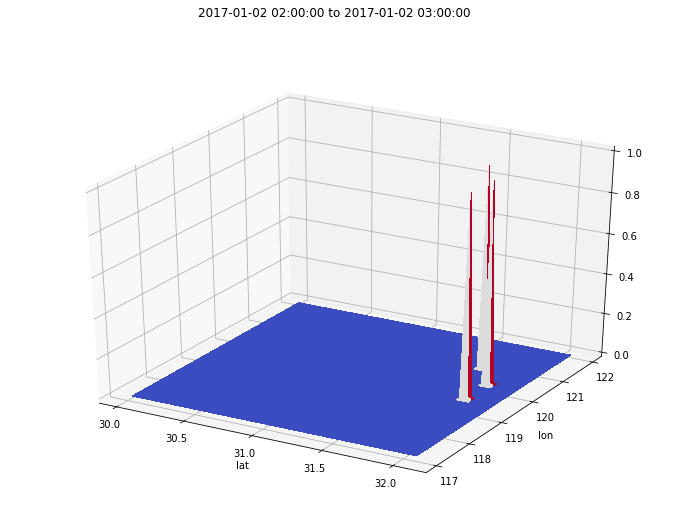

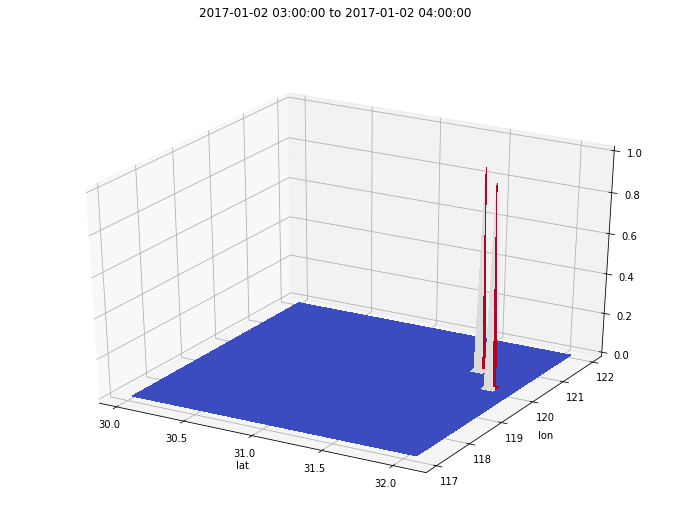

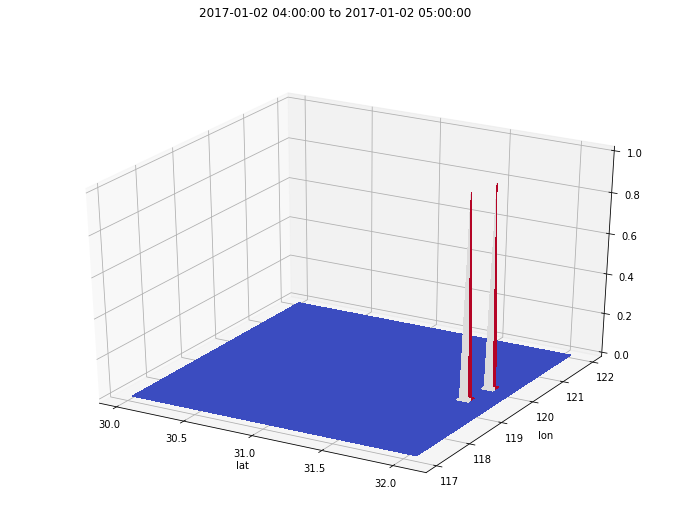

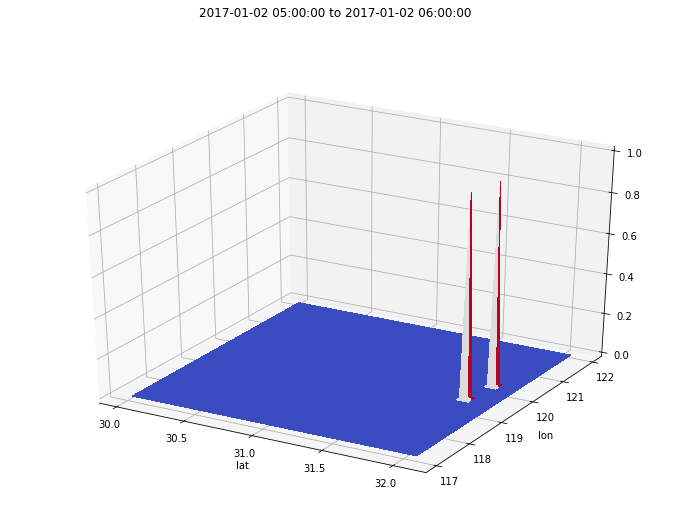

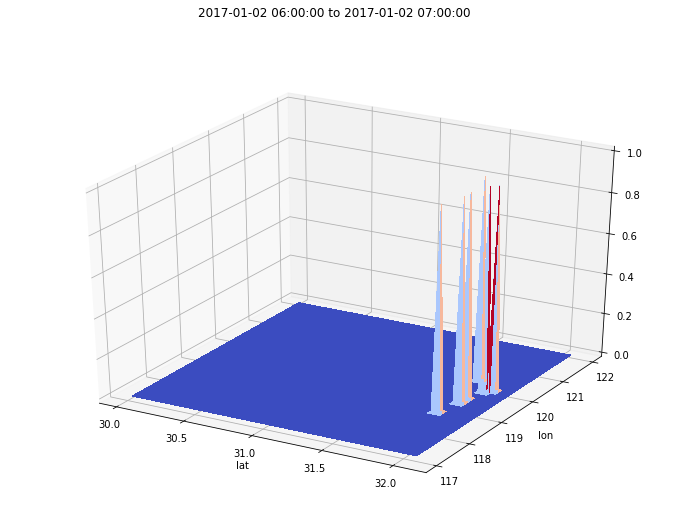

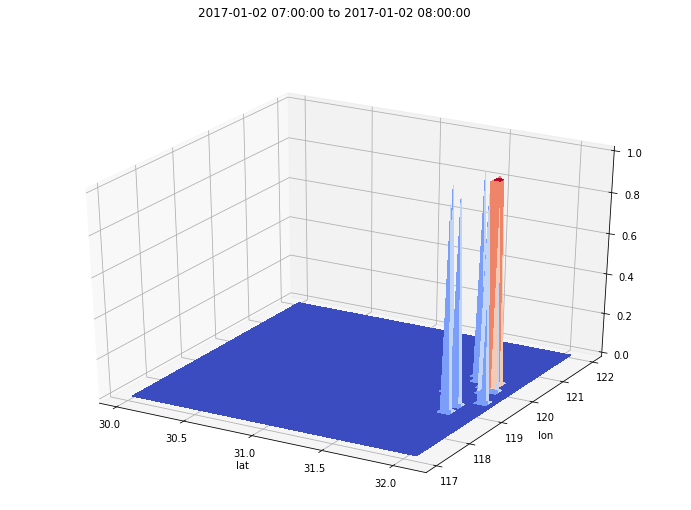

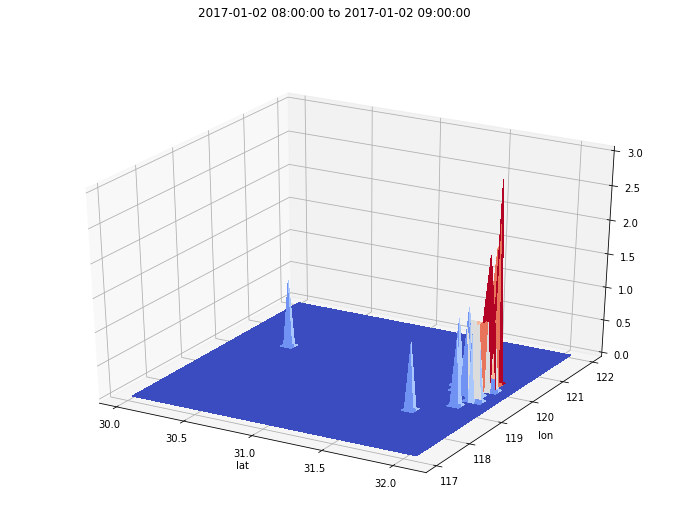

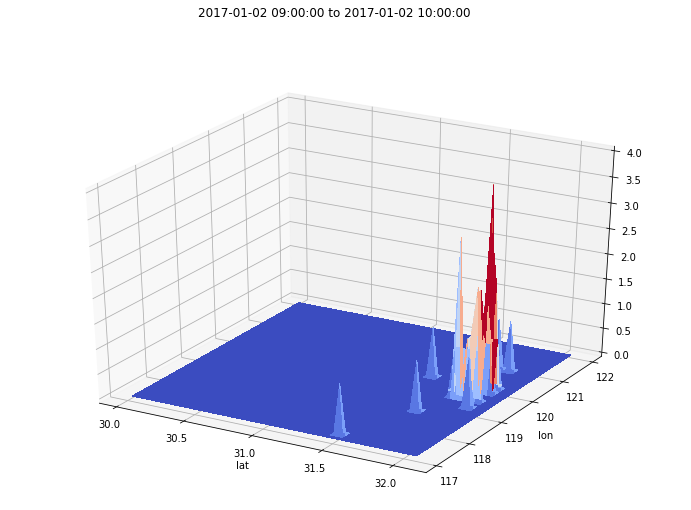

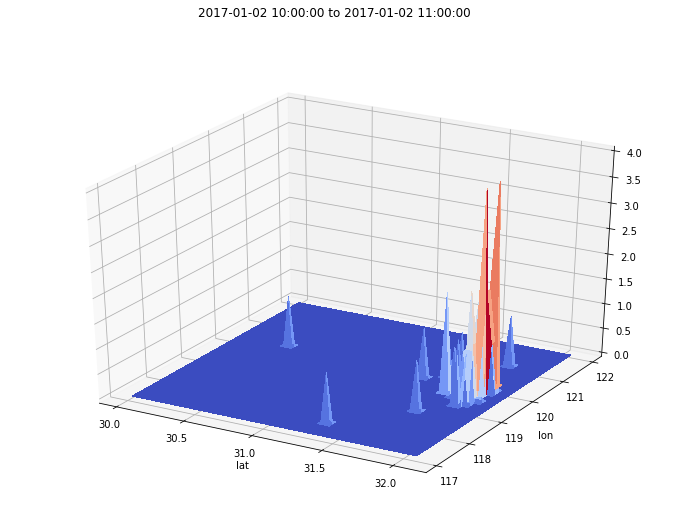

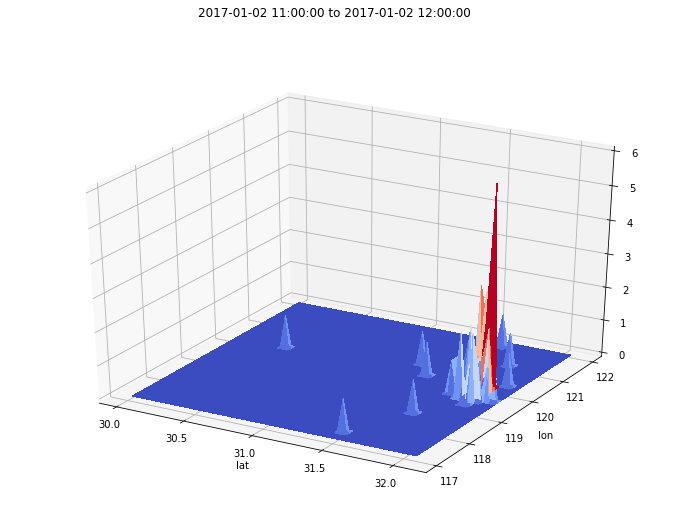

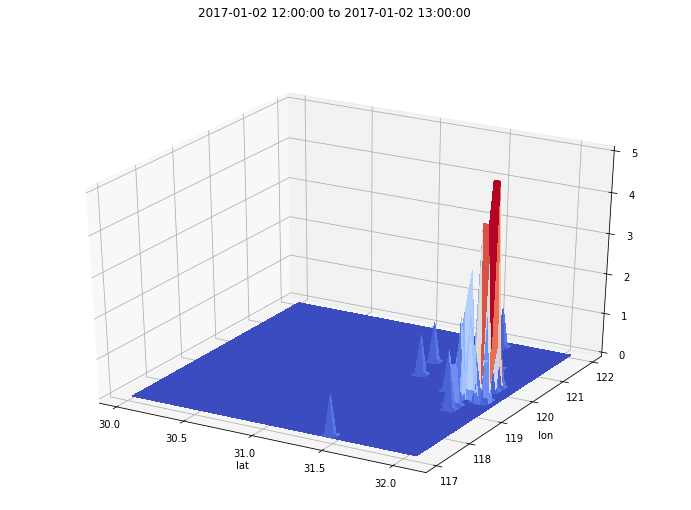

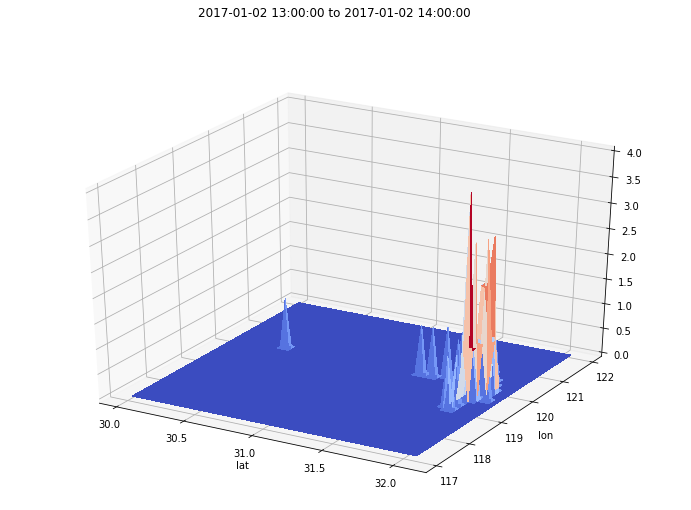

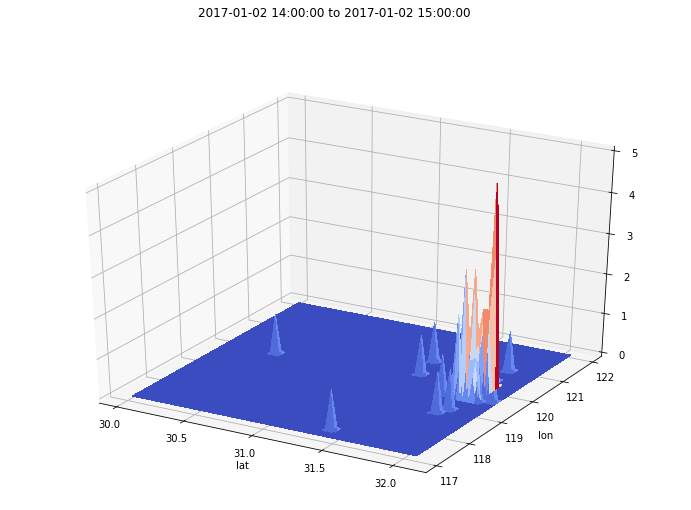

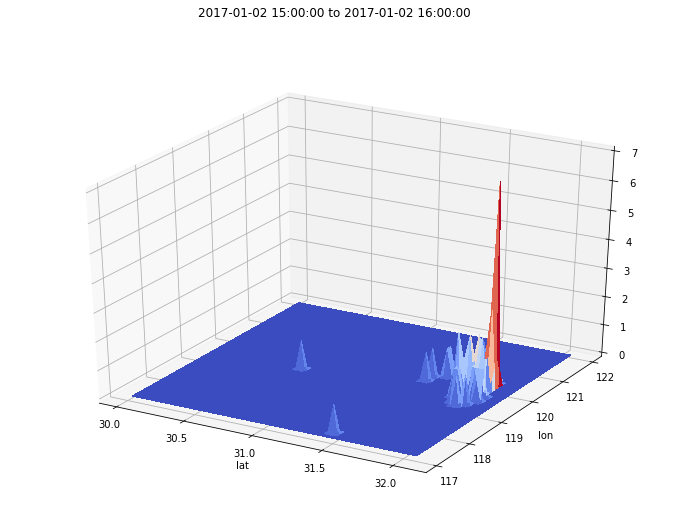

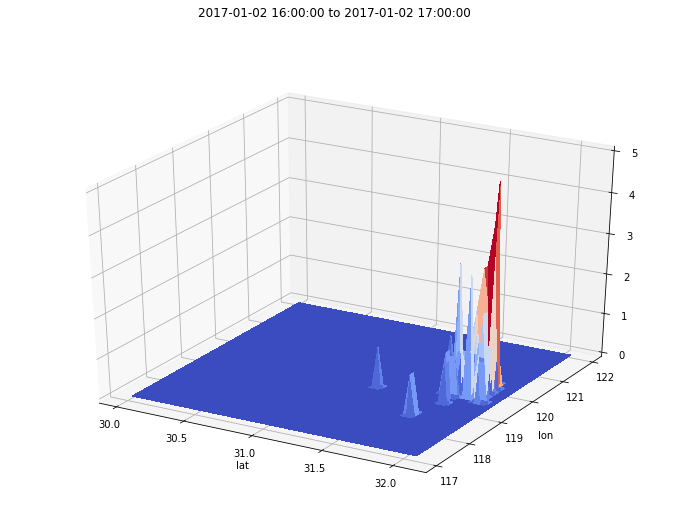

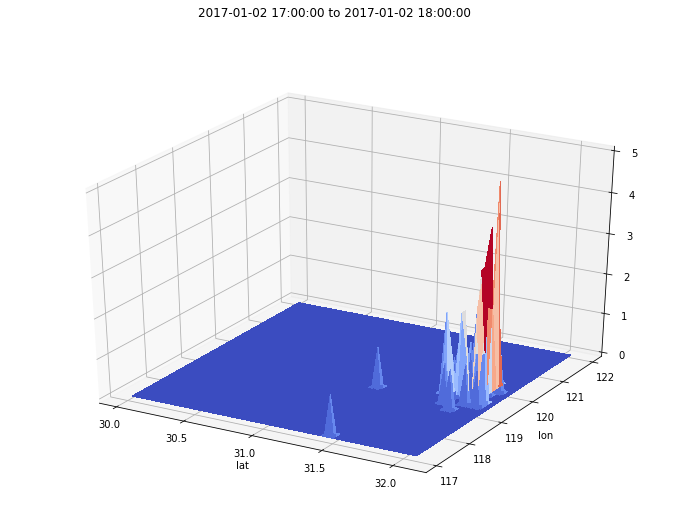

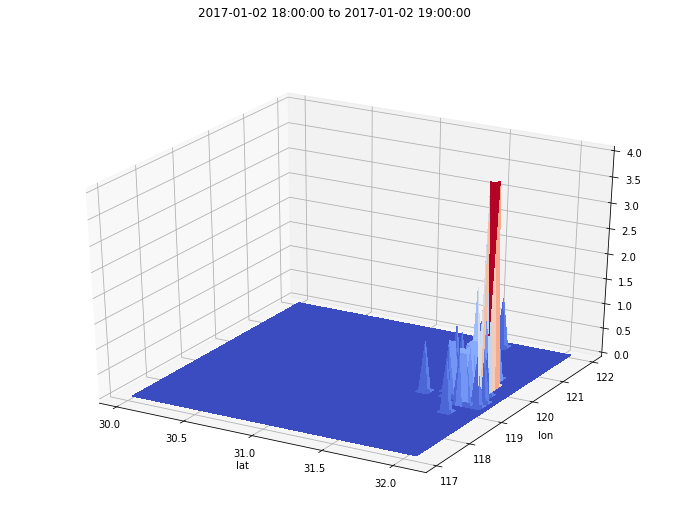

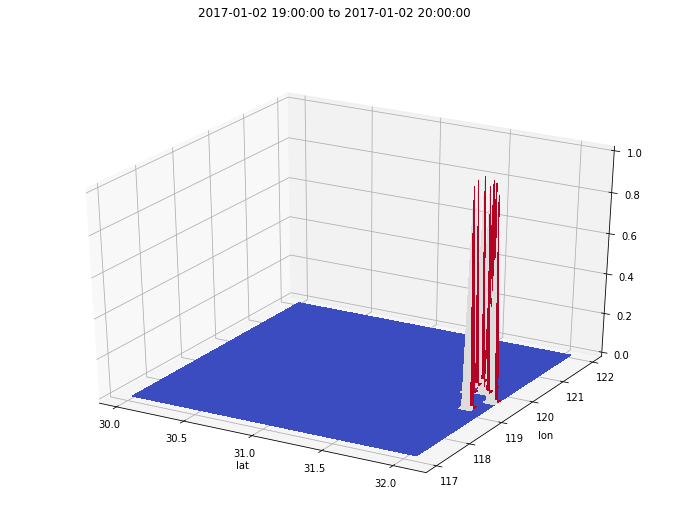

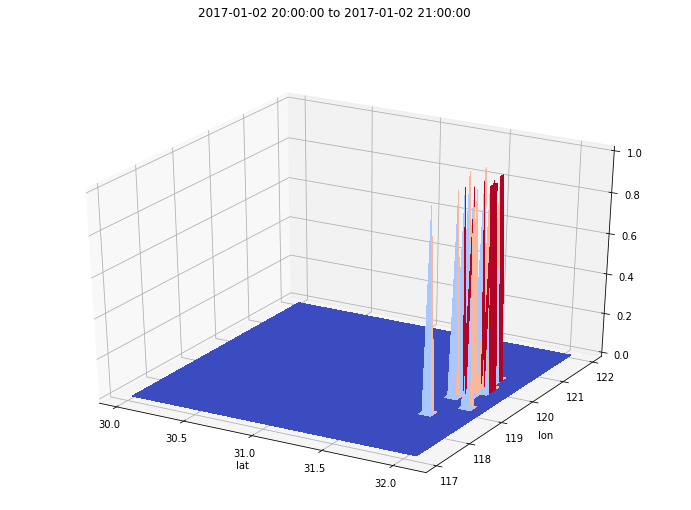

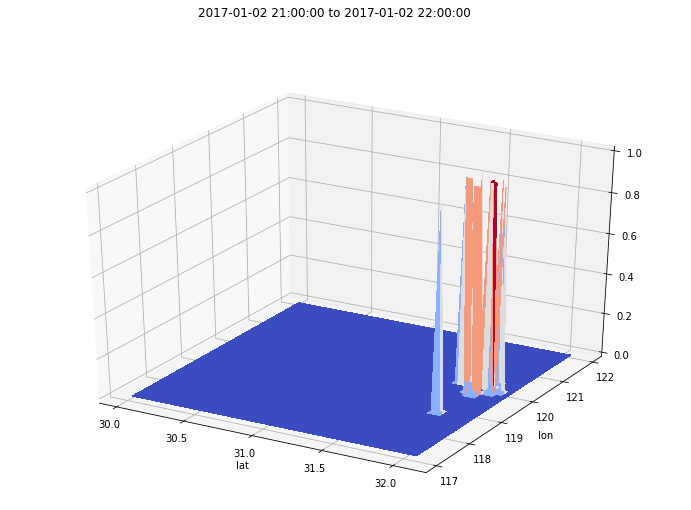

In [143]:
for hour in range(0, 23):
    draw_hour_hist(datetime(2017, 1, 2, hour),
              datetime(2017, 1, 2, hour + 1))

In [144]:
draw_hour_hist(datetime(2017, 1, 2, 23),
              datetime(2017, 1, 3, 0))

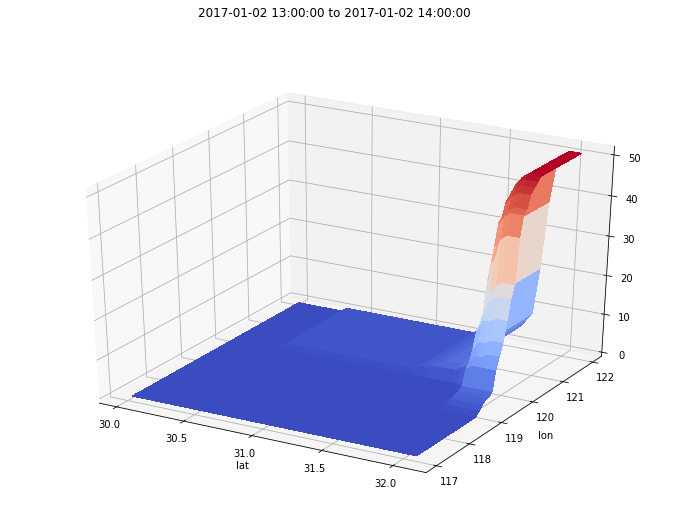

In [154]:
def integrate_density(hist):
    for col in range(1,hist.shape[1]):
        hist[0][col] += hist[0][col-1];
    for row in range(1,hist.shape[0]):
        hist[row][0] += hist[row-1][0]
        for col in range(1,hist.shape[1]):
            hist[row][col] += (hist[row][col-1] + hist[row-1][col] 
                               - hist[row-1][col-1]);
    return hist

def draw_hour_dist(hour_begin, hour_end):
    bins_ctr = 50
    lat_min, lat_max = 30.0, 32.1
    lon_min, lon_max = 117, 122
    x_gap = (lat_max - lat_min) / bins_ctr / 2;
    y_gap = (lon_max - lon_min) / bins_ctr / 2;
    data_hour = data[(hour_begin <= data['date_time']) & (data['date_time'] < hour_end)]
    data_hour = data_hour.drop_duplicates(['car_id'])
    # if there is only one car, code will throw error
    if data_hour.shape[0] < 2:
        return
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    hist, xedges, yedges = np.histogram2d(data_hour['lat'], data_hour['lon'],
                                         bins = bins_ctr, range = [[lat_min, lat_max], [lon_min, lon_max]])
    xpos, ypos = np.meshgrid(xedges[:-1] + x_gap, yedges[:-1] + y_gap)
    
    # get the joint distribution
    hist = integrate_density(hist)
            
    ax.plot_surface(xpos, ypos, hist, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
    ax.set_xlabel("lat")
    ax.set_ylabel("lon")
    #ax.set_zlim(0, 2000)
    fig.suptitle("{} to {}".format(hour_begin, hour_end))
    plt.show()
    fig.savefig("./fig/{}.png".format(hour_begin))
draw_hour_dist(datetime(2017, 1, 2, 13), datetime(2017, 1, 2, 14))

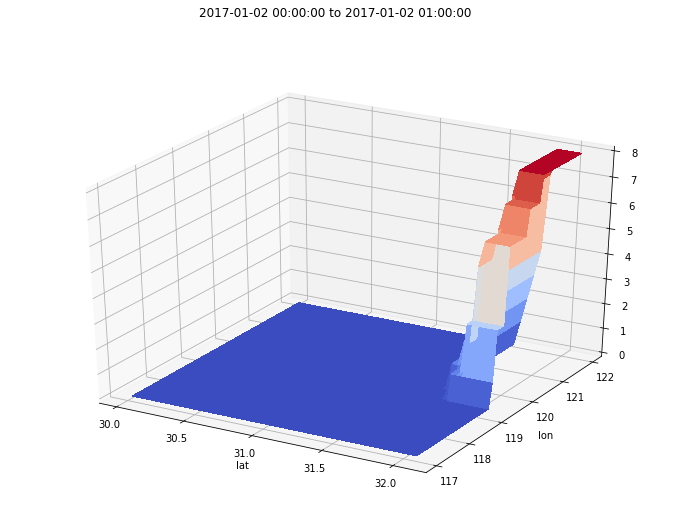

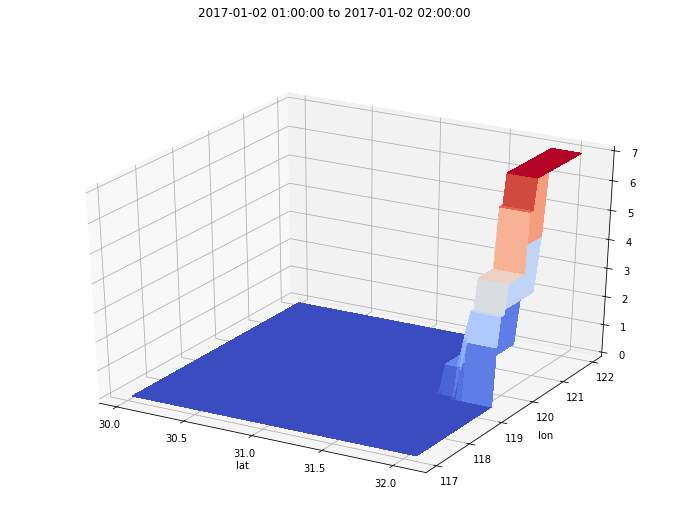

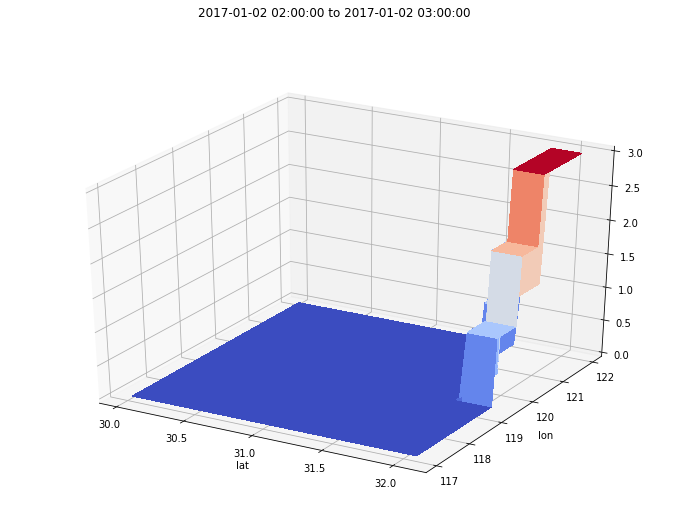

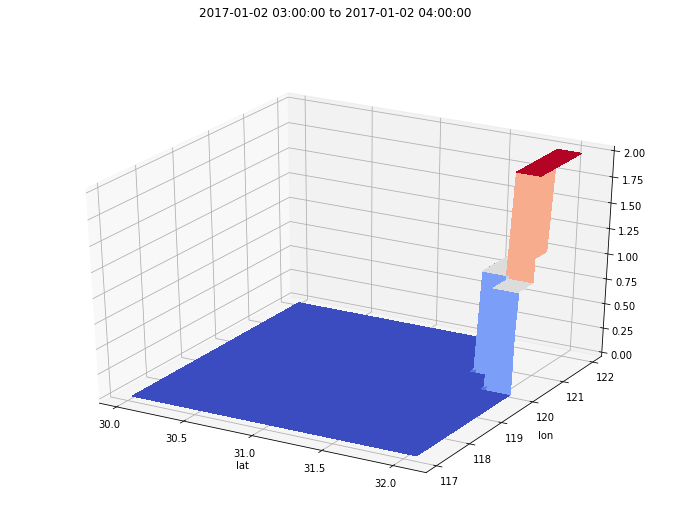

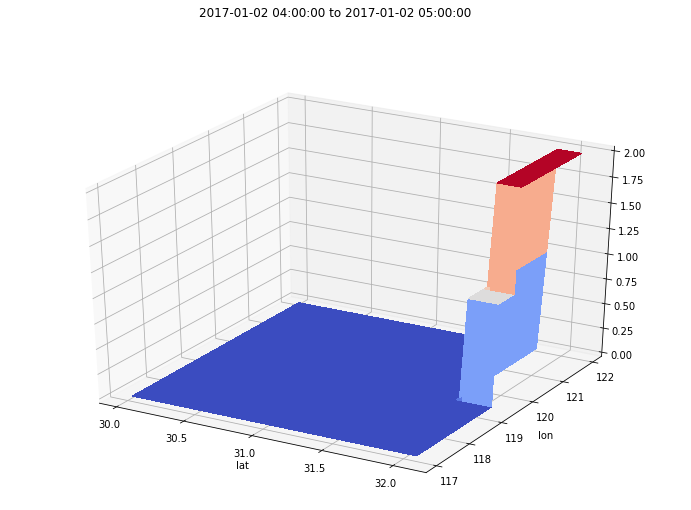

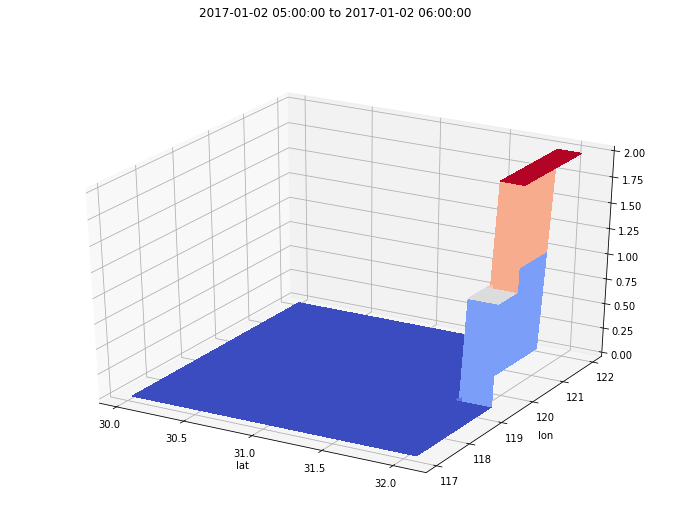

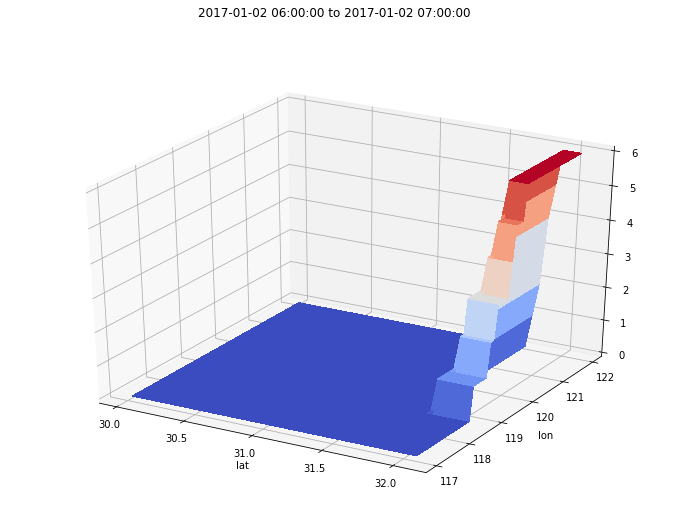

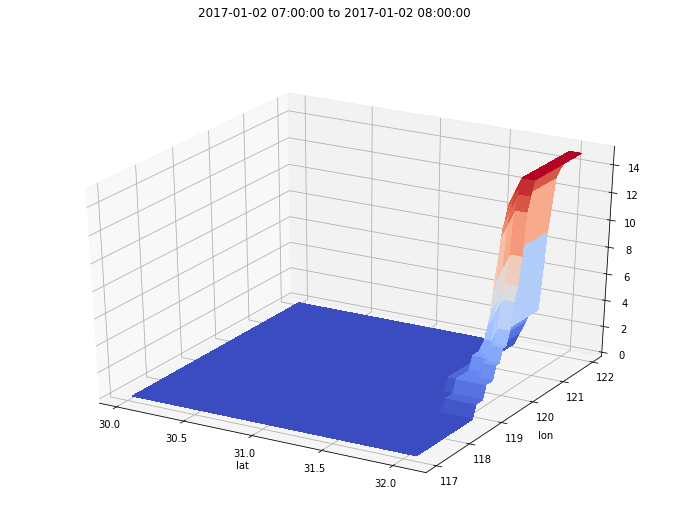

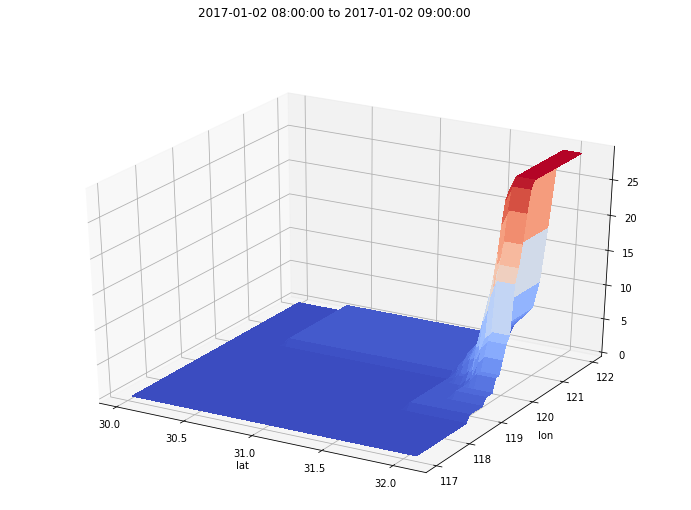

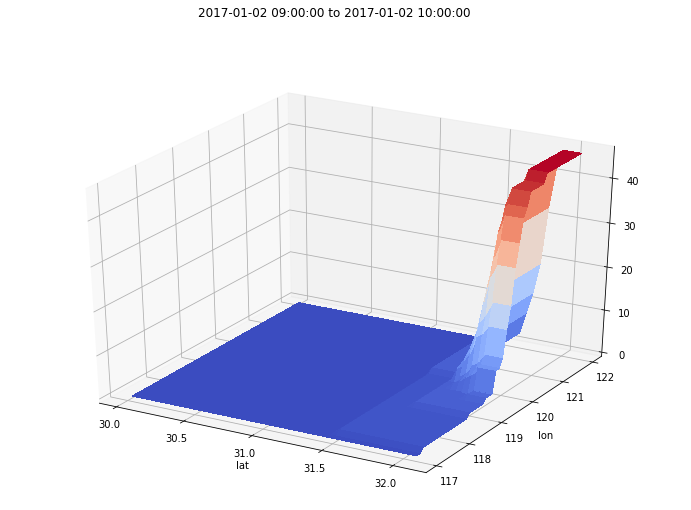

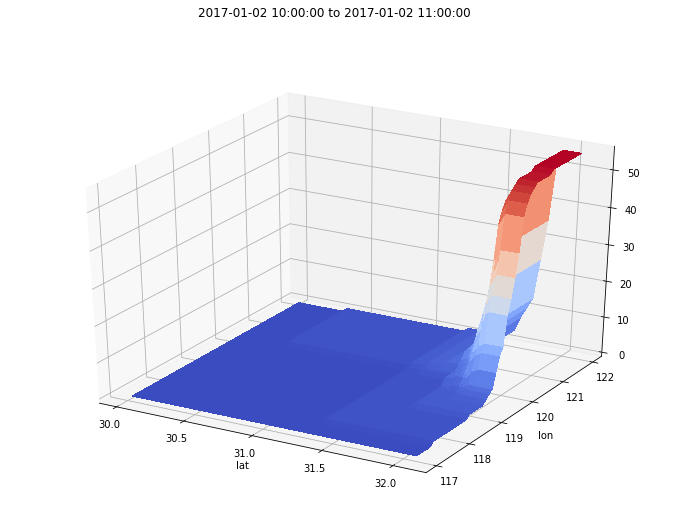

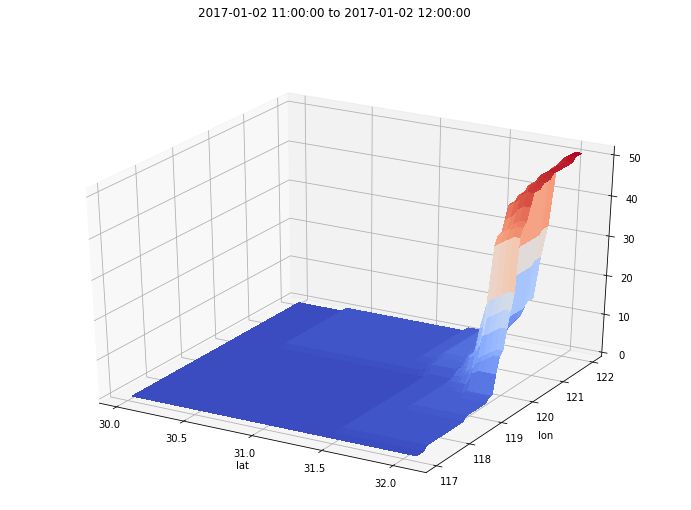

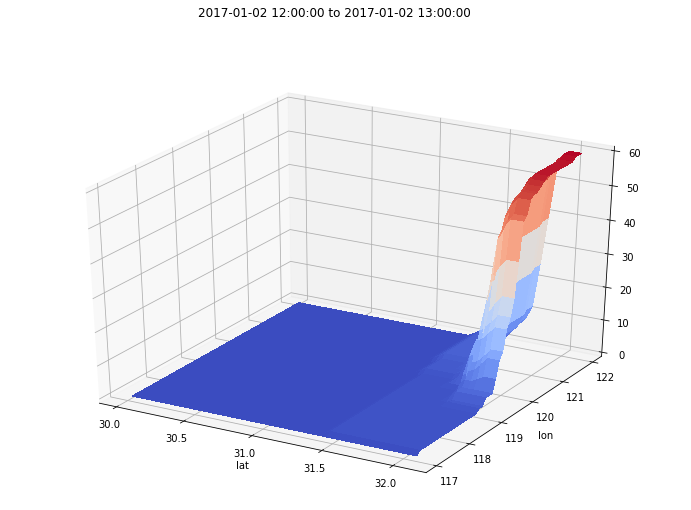

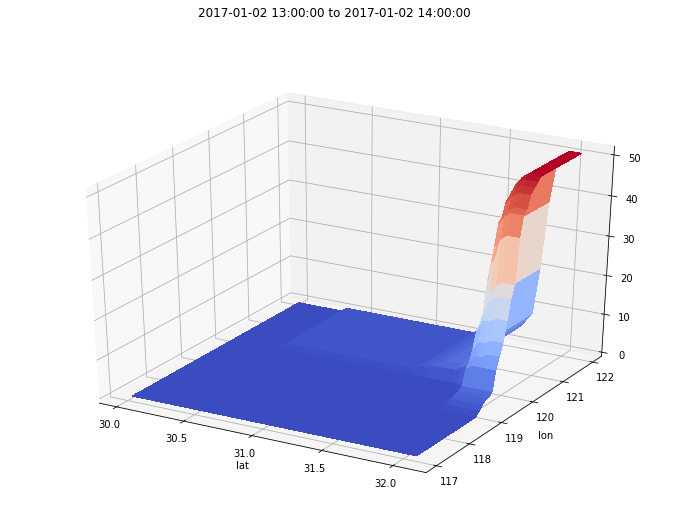

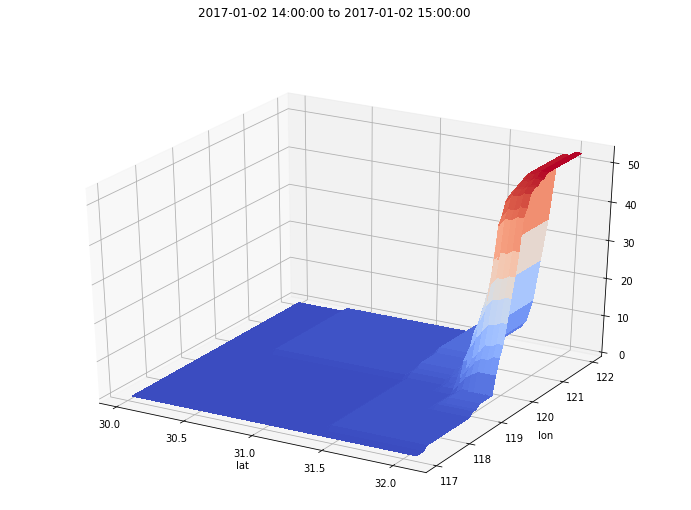

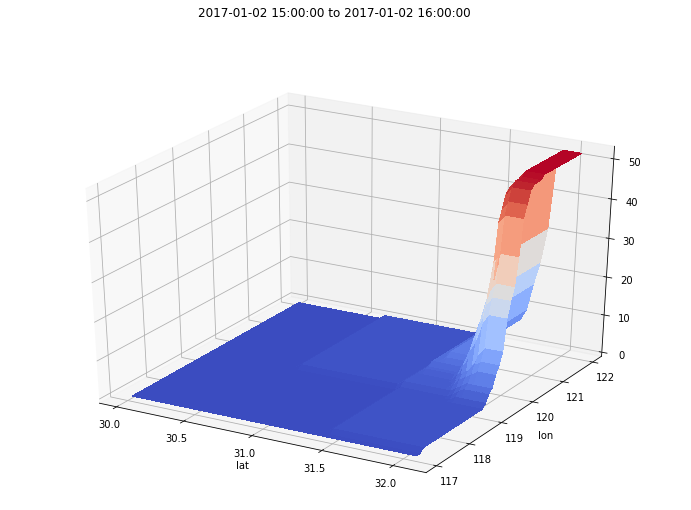

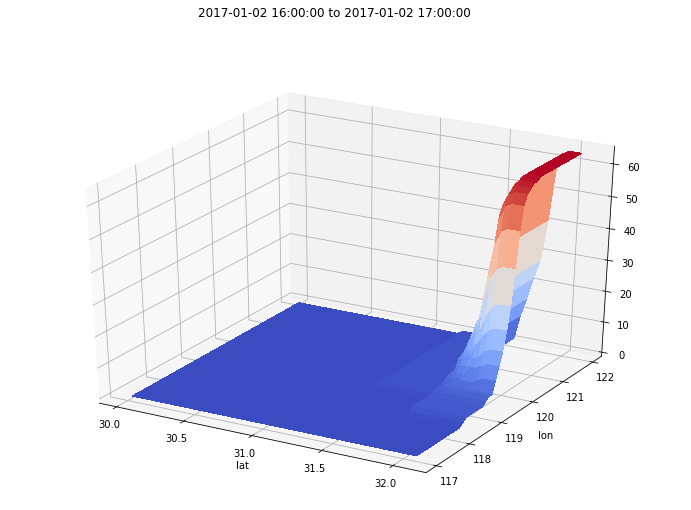

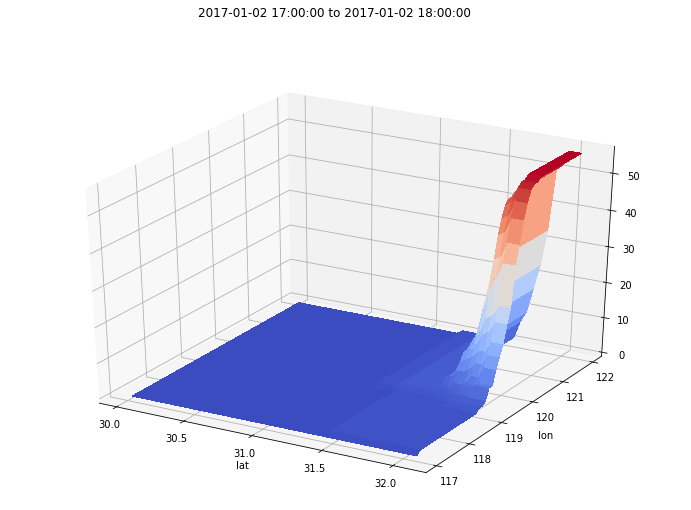

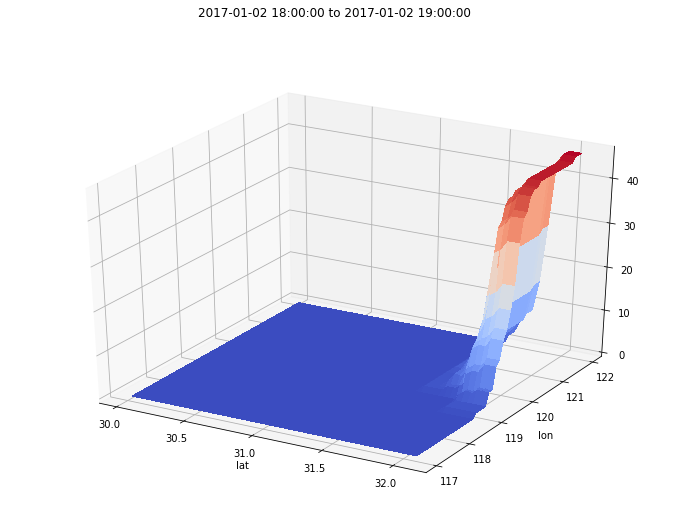

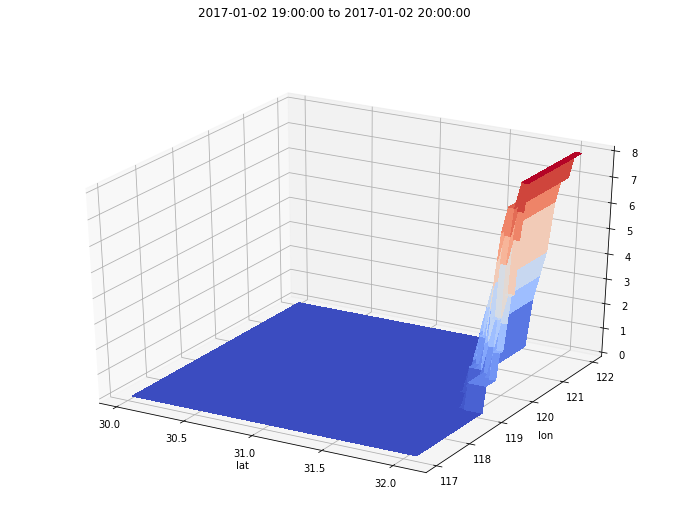

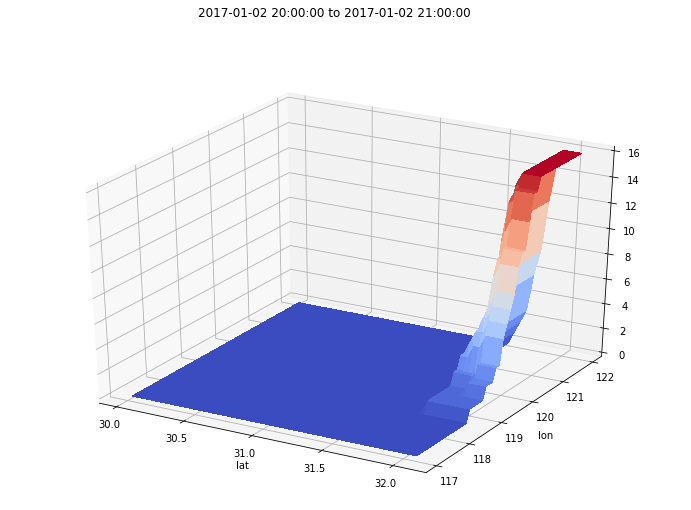

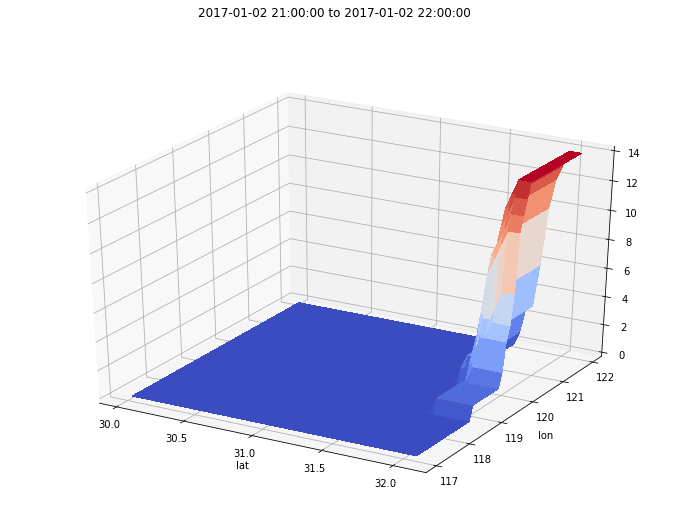

In [151]:
for hour in range(0, 23):
    draw_hour_dist(datetime(2017, 1, 2, hour),
              datetime(2017, 1, 2, hour + 1))